> 🩺 Este notebook forma parte del proyecto **NutriSynthCare**, un entorno de simulación sobre salud pública y recomendaciones nutricionales personalizadas.  
>
> 👥 Desarrollado por:  
> - Daniel Cruz – [dCruzCoding](https://github.com/dCruzCoding)  
> - Aníbal García – [Aniballll](https://github.com/Aniballll)  
>
> 📁 Repositorio completo: [NutriSynthCare](https://github.com/dCruzCoding/NutriSynthCare)   
>
> 📜 Licencia: Este proyecto está disponible bajo la licencia MIT. Consulta el archivo `LICENSE` para más información.  
>
> 🙏 Agradecimientos especiales a todas las fuentes de datos y literatura científica que han hecho posible la creación de las bases sintéticas utilizadas en este proyecto.  
>
> 🤝 ¿Te interesa colaborar? ¡Estás invitado!  
> Puedes contribuir mejorando los notebooks, proponiendo nuevas ideas o corrigiendo errores:  
> - Haz un fork del repo  
> - Crea una rama (`git checkout -b mejora/nueva-idea`)  
> - Abre un Pull Request explicando tu propuesta



--- Entrenando Autoencoder ---
Pérdida final del Autoencoder (entrenamiento): 0.0810
Pérdida final del Autoencoder (validación): 0.0846


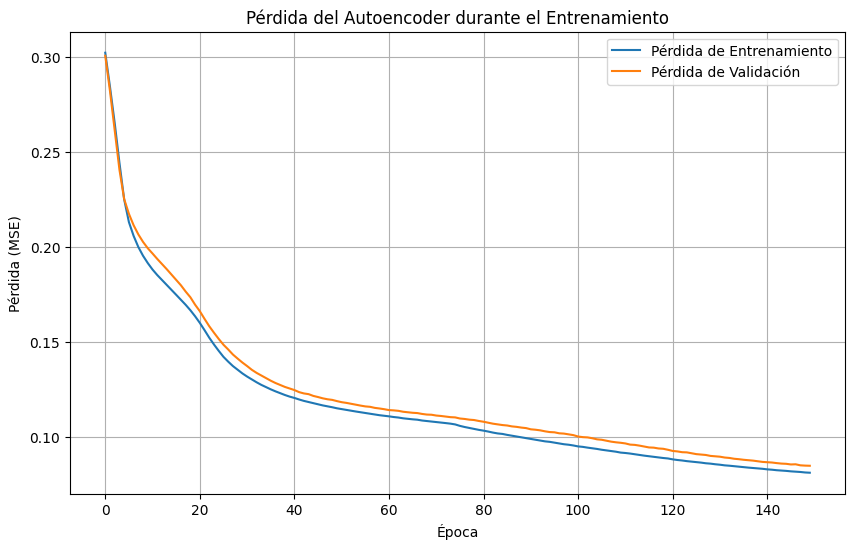

32/32 [==============================] - 0s 974us/step


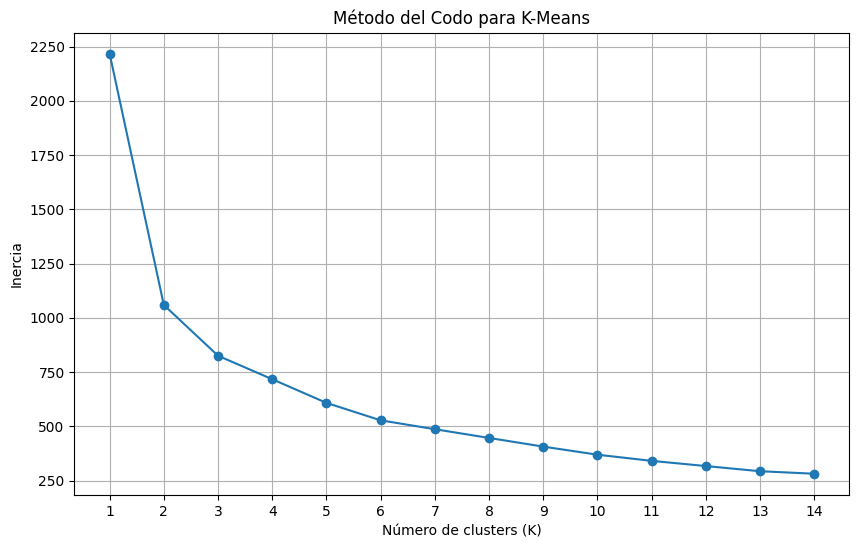


--- Estadísticas por perfil (valores promedio) ---
             Edad        IMC     HbA1c  Presion_Sistolica         LDL  \
Perfil                                                                  
0       51.490909  29.950909  7.495455         137.709091  160.090909   
1       53.249084  29.047253  7.648718         133.216117  152.307692   
2       52.433551  29.133769  7.003268         138.254902  160.827887   
3       50.151899  28.355696  7.000633         133.424051  159.246835   

              HDL   Insulina  Trigliceridos  Frecuencia_Cardiaca  
Perfil                                                            
0       61.145455  16.709330     224.309091            76.272727  
1       57.967033  16.857980     240.113553            74.388278  
2       60.407407  16.710533     238.677560            75.328976  
3       59.936709  16.166280     218.797468            74.683544  


In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from rdflib import Graph, Namespace, RDF, RDFS, Literal
import re

import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suprime warnings de TensorFlow (info y warnings)
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # Solo muestra errores de TensorFlow
warnings.filterwarnings('ignore') # Ignora warnings generales

# Cargar datos
try:
    df_diabetes = pd.read_csv('datos_diabetes_sinteticos.csv')
except FileNotFoundError:
    print("Asegúrate de que 'datos_diabetes_sinteticos.csv' está en la misma carpeta.")
    exit()

# --- Preprocesamiento de datos de diabetes ---
variables_numericas = ['Edad', 'IMC', 'HbA1c', 'Presion_Sistolica', 'LDL', 'HDL', 'Insulina', 'Trigliceridos', 'Frecuencia_Cardiaca']
variables_categoricas = ['Sexo', 'Diabetes', 'Consumo_Alcohol', 'Actividad_Fisica', 'Nivel_Estres']

for col in variables_numericas:
    if col in df_diabetes.columns:
        df_diabetes[col] = pd.to_numeric(df_diabetes[col], errors='coerce')
        df_diabetes[col].fillna(df_diabetes[col].mean(), inplace=True)

scaler = StandardScaler()
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

existing_categorical_cols = [col for col in variables_categoricas if col in df_diabetes.columns]
X_categoricas = encoder.fit_transform(df_diabetes[existing_categorical_cols]).toarray()
X_numericas = scaler.fit_transform(df_diabetes[variables_numericas])


X = np.concatenate([X_categoricas], axis=1)

# --- Autoencoder y K-Means  ---
input_dim = X.shape[1]
encoding_dim = 8
input_layer = Input(shape=(input_dim,))
encoded = Dense(input_dim // 2, activation='relu')(input_layer)
encoded = Dense(encoding_dim * 2, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
decoded = Dense(input_dim // 2, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)
autoencoder = Model(input_layer, decoded)
encoder_model = Model(input_layer, encoded)
autoencoder.compile(optimizer='adam', loss='mse')

print("\n--- Entrenando Autoencoder ---")
history = autoencoder.fit(X, X, epochs=150, batch_size=64, validation_split=0.2, verbose=0)
print(f"Pérdida final del Autoencoder (entrenamiento): {history.history['loss'][-1]:.4f}")
print(f"Pérdida final del Autoencoder (validación): {history.history['val_loss'][-1]:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Autoencoder durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

X_encoded = encoder_model.predict(X)

inertia = []
K_range = range(1, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_encoded)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.xticks(K_range)
plt.grid(True)
plt.show()

k_optimo = 4
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_diabetes['Perfil'] = kmeans.fit_predict(X_encoded)

perfiles_stats = df_diabetes.groupby('Perfil')[variables_numericas].mean()
print("\n--- Estadísticas por perfil (valores promedio) ---")
print(perfiles_stats)

In [7]:
# --- Construcción de la Ontología  ---
g = Graph()

FOOD = Namespace("http://example.org/food/")
NUT = Namespace("http://example.org/nutrient/")
COND = Namespace("http://example.org/condition/")
EX = Namespace("http://example.org/ex/")
PROF = Namespace("http://example.org/profile/")

g.bind("food", FOOD)
g.bind("nut", NUT)
g.bind("cond", COND)
g.bind("ex", EX)
g.bind("prof", PROF)

g.add((FOOD.Food, RDF.type, RDFS.Class))
g.add((NUT.Nutrient, RDF.type, RDFS.Class))
g.add((COND.Condition, RDF.type, RDFS.Class))
g.add((PROF.Profile, RDF.type, RDFS.Class))

g.add((EX.hasCondition, RDF.type, RDF.Property))
g.add((EX.beneficialFor, RDF.type, RDF.Property))
g.add((EX.harmfulFor, RDF.type, RDF.Property)) 
g.add((NUT.containsNutrient, RDF.type, RDF.Property))
g.add((PROF.hasNutritionalRecommendation, RDF.type, RDF.Property))

for profile_id in df_diabetes['Perfil'].unique():
    profile_uri = getattr(PROF, f"Profile_{profile_id}")
    g.add((profile_uri, RDF.type, PROF.Profile))

# Nutrientes y sus beneficios 
nutrient_benefits = {
    "Fiber": ["Diabetes", "HighCholesterol", "Overweight"],
    "Omega3": ["Hypertension", "HighCholesterol", "Diabetes"],
    "Calcium": ["Hypertension", "Underweight"],
    "Magnesium": ["Hypertension", "Diabetes"],
    "Protein": ["Underweight", "Diabetes", "Overweight"],
    "VitaminD": ["HighCholesterol", "Diabetes", "Underweight"],
    "Potassium": ["Hypertension"],
    "Antioxidants": ["Diabetes", "HighCholesterol"]
}

for nutrient, conditions in nutrient_benefits.items():
    g.add((getattr(NUT, nutrient), RDF.type, NUT.Nutrient))
    for condition_name in conditions:
        g.add((getattr(NUT, nutrient), EX.beneficialFor, getattr(COND, condition_name)))

# ¡Nuevo! Nutrientes cuyo consumo se debe 
nutrient_harms = {
    "Sodium": ["Hypertension"],
    "SaturatedFat": ["HighCholesterol", "Diabetes"], # Ejemplo: Grasas saturadas
    "SimpleSugars": ["Diabetes", "Overweight"] # Ejemplo: Azúcares simples
}

for nutrient, conditions in nutrient_harms.items():
    g.add((getattr(NUT, nutrient), RDF.type, NUT.Nutrient))
    for condition_name in conditions:
        g.add((getattr(NUT, nutrient), EX.harmfulFor, getattr(COND, condition_name)))


# Alimentos y sus nutrientes 
food_nutrients = {
    "Salmon": ["Omega3", "Protein", "VitaminD"],
    "Walnuts": ["Omega3", "Magnesium", "Antioxidants", "Protein", "Fiber"],
    "Lentils": ["Fiber", "Protein", "Magnesium"],
    "Spinach": ["Magnesium", "Calcium", "Fiber", "Antioxidants"],
    "Yogurt": ["Calcium", "Protein"],
    "Oats": ["Fiber", "Magnesium", "Protein"],
    "Blueberries": ["Antioxidants", "Fiber"],
    "Almonds": ["Magnesium", "Protein", "Fiber", "Antioxidants"],
}

for food, nutrients in food_nutrients.items():
    g.add((getattr(FOOD, food), RDF.type, FOOD.Food))
    for nutrient in nutrients:
        g.add((getattr(FOOD, food), NUT.containsNutrient, getattr(NUT, nutrient)))

# Función para obtener condiciones del paciente individual 
def get_patient_conditions(patient_data_row):
    conditions = set()
    hba1c = patient_data_row.get('HbA1c', 0)
    presion = patient_data_row.get('Presion_Sistolica', 0)
    ldl = patient_data_row.get('LDL', 0)
    imc = patient_data_row.get('IMC', 0)

    if hba1c > 6.5:
        conditions.add("Diabetes")
    if presion > 130:
        conditions.add("Hypertension")
    if ldl > 100:
        conditions.add("HighCholesterol")
    if imc > 25:
        conditions.add("Overweight")
    elif imc < 18.5:
        conditions.add("Underweight")
        
    return list(conditions)

# Función para obtener los nutrientes recomendados 
def get_recommended_nutrients_for_patient(patient_conditions):
    nutrients_to_increase = set()
    nutrients_to_decrease = set()

    for condition_name in patient_conditions:
        condition_uri = getattr(COND, condition_name)
        
        # Nutrientes beneficiosos (para aumentar)
        beneficial_nuts = [subj for subj, pred, obj in g.triples((None, EX.beneficialFor, condition_uri))]
        nutrients_to_increase.update([str(n).split('/')[-1] for n in beneficial_nuts])

        # Nutrientes perjudiciales (para disminuir)
        harmful_nuts = [subj for subj, pred, obj in g.triples((None, EX.harmfulFor, condition_uri))]
        nutrients_to_decrease.update([str(n).split('/')[-1] for n in harmful_nuts])
    
    return sorted(list(nutrients_to_increase)), sorted(list(nutrients_to_decrease))

In [8]:
# --- Visualización de resultados ---

def display_patient_recommendations(patient_id):
    patient_data = df_diabetes[df_diabetes['ID_Paciente'] == patient_id]

    if patient_data.empty:
        print(f"No se encontraron datos para el paciente {patient_id}.")
        return

    patient_data_row = patient_data.iloc[0]

    print(f"\n--- Informe Personalizado de Salud y Nutrición para Paciente {patient_id} ---")

    ## 1. Características del Paciente
    print("\n## 1. Características del Paciente")
    print("---------------------------------")
    display_cols = ['Edad', 'Sexo', 'IMC', 'HbA1c', 'Presion_Sistolica', 'LDL', 'HDL', 'Insulina', 'Trigliceridos', 'Frecuencia_Cardiaca', 'Diabetes', 'Consumo_Alcohol', 'Actividad_Fisica', 'Nivel_Estres', 'Perfil']
    existing_display_cols = [col for col in display_cols if col in patient_data.columns]
    
    patient_info_dict = {}
    for col in existing_display_cols:
        value = patient_data_row.get(col, "No disponible")
        if pd.isna(value) or value == "No disponible":
            patient_info_dict[col] = "No disponible"
        elif isinstance(value, (int, float)):
            patient_info_dict[col] = f"{value:.2f}" if isinstance(value, float) else str(int(value))
        else:
            patient_info_dict[col] = str(value)
            
    max_len_col = max(len(col) for col in patient_info_dict.keys()) if patient_info_dict else 0
    for col, val in patient_info_dict.items():
        print(f"**{col.ljust(max_len_col)}**: {val}")

    ## 2. Condiciones de Salud Detectadas
    detected_conditions = get_patient_conditions(patient_data_row)
    
    print("\n## 2. Condiciones de Salud Detectadas")
    print("-------------------------------------")
    if detected_conditions:
        for cond in sorted(list(set(detected_conditions))):
            print(f"- **{cond}**")
    else:
        print("Ninguna condición de salud específica detectada para este paciente basada en sus datos.")

    ## 3. Recomendaciones Nutricionales
    nutrients_to_increase, nutrients_to_decrease = get_recommended_nutrients_for_patient(detected_conditions)

    print("\n## 3. Recomendaciones Nutricionales")
    print("-----------------------------------")
    
    if nutrients_to_increase or nutrients_to_decrease:
        print("Basado en sus condiciones de salud, se recomienda prestar atención a los siguientes nutrientes:")
        
        if nutrients_to_increase:
            print("\n**Aumentar el consumo de:**")
            for nut in nutrients_to_increase:
                print(f"- **{nut}**")
        
        if nutrients_to_decrease:
            print("\n**Disminuir o limitar el consumo de:**")
            for nut in nutrients_to_decrease:
                print(f"- **{nut}**")
    else:
        print("No se identificaron nutrientes específicos para recomendar en base a las condiciones detectadas.")

    print("\n*Recuerde que estas son recomendaciones generales. Consulte a un profesional de la salud para un plan nutricional personalizado.*")


# Ejemplo de uso de la función de visualización
patient_id_to_check = 'P0250' # Paciente de ejemplo para probar la nueva salida.
display_patient_recommendations(patient_id_to_check)


--- Informe Personalizado de Salud y Nutrición para Paciente P0250 ---

## 1. Características del Paciente
---------------------------------
**Edad               **: 20
**Sexo               **: Femenino
**IMC                **: 20.80
**HbA1c              **: 4.20
**Presion_Sistolica  **: 91
**LDL                **: 150
**HDL                **: 51
**Insulina           **: 28.30
**Trigliceridos      **: 371
**Frecuencia_Cardiaca**: 77
**Diabetes           **: False
**Consumo_Alcohol    **: Nunca
**Actividad_Fisica   **: Intenso
**Nivel_Estres       **: Alto
**Perfil             **: 2

## 2. Condiciones de Salud Detectadas
-------------------------------------
- **HighCholesterol**

## 3. Recomendaciones Nutricionales
-----------------------------------
Basado en sus condiciones de salud, se recomienda prestar atención a los siguientes nutrientes:

**Aumentar el consumo de:**
- **Antioxidants**
- **Fiber**
- **Omega3**
- **VitaminD**

**Disminuir o limitar el consumo de:**
- **SaturatedF